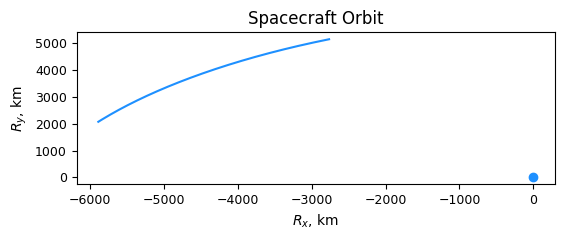

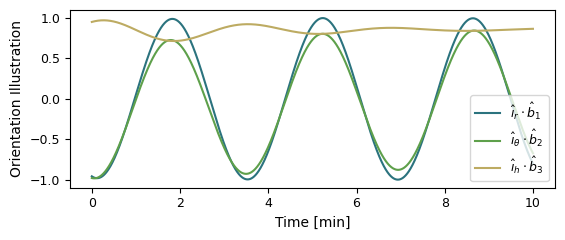

In [3]:
# Get current file path
import inspect
import os
import sys

# Import utilities
from Basilisk.utilities import orbitalMotion, macros, vizSupport

filename = inspect.getframeinfo(inspect.currentframe()).filename
path = os.getcwd()

# Import master classes: simulation base class and scenario base class
sys.path.append(path + '/../')
sys.path.append(path + '/../models')
sys.path.append(path + '/../plotting')
from sim_masters import Sim, Scenario
import cubesat_dynamics, cubesat_fsw
import cubesat_plotting as plots

# Create your own scenario child class
class scenario_BasicOrbit(Sim, Scenario):
    def __init__(self):
        super(scenario_BasicOrbit, self).__init__()
        self.name = 'scenario_BasicOrbit'

        # declare empty class variables
        self.sNavAttRec = None
        self.sNavTransRec = None

        self.set_DynModel(cubesat_dynamics)
        self.set_FswModel(cubesat_fsw)

        self.configure_initial_conditions()
        self.log_outputs()

    def configure_initial_conditions(self):
        DynModels = self.get_DynModel()

        # Configure Dynamics initial conditions
        oe = orbitalMotion.ClassicElements()
        oe.a = 7000000.0  # meters
        oe.e = 0.1
        oe.i = 33.3 * macros.D2R
        oe.Omega = 48.2 * macros.D2R
        oe.omega = 347.8 * macros.D2R
        oe.f = 85.3 * macros.D2R
        mu = DynModels.gravFactory.gravBodies['earth'].mu
        rN, vN = orbitalMotion.elem2rv(mu, oe)
        orbitalMotion.rv2elem(mu, rN, vN)
        DynModels.scObject.hub.r_CN_NInit = rN  # m   - r_CN_N
        DynModels.scObject.hub.v_CN_NInit = vN  # m/s - v_CN_N
        DynModels.scObject.hub.sigma_BNInit = [[0.1], [0.2], [-0.3]]  # sigma_BN_B
        DynModels.scObject.hub.omega_BN_BInit = [[0.001], [-0.01], [0.03]]  # rad/s - omega_BN_B

    def log_outputs(self):
        # Dynamics process outputs
        DynModels = self.get_DynModel()
        self.sNavAttRec = DynModels.simpleNavObject.attOutMsg.recorder()
        self.sNavTransRec = DynModels.simpleNavObject.transOutMsg.recorder()
        self.AddModelToTask(DynModels.taskName, self.sNavAttRec)
        self.AddModelToTask(DynModels.taskName, self.sNavTransRec)

    def pull_outputs(self, showPlots):
        # Dynamics process outputs
        sigma_BN = self.sNavAttRec.sigma_BN
        r_BN_N = self.sNavTransRec.r_BN_N
        v_BN_N = self.sNavTransRec.v_BN_N

        # Plot results
        plots.clear_all_plots()
        timeLineSet = self.sNavAttRec.times() * macros.NANO2MIN
        plots.plot_orbit(r_BN_N)
        plots.plot_orientation(timeLineSet, r_BN_N, v_BN_N, sigma_BN)

        figureList = {}
        if showPlots:
            plots.show_all_plots()
        else:
            fileName = os.path.basename(os.path.splitext(__file__)[0])
            figureNames = ["orbit", "orientation"]
            figureList = plots.save_all_plots(fileName, figureNames)

        return figureList


def runScenario(scenario):

    # Initialize simulation
    scenario.InitializeSimulation()

    # Configure FSW mode
    scenario.modeRequest = 'standby'

    # Configure run time and execute simulation
    simulationTime = macros.min2nano(10.)
    scenario.ConfigureStopTime(simulationTime)

    scenario.ExecuteSimulation()


def run(showPlots):

    # Configure a scenario in the base simulation
    TheScenario = scenario_BasicOrbit()
    runScenario(TheScenario)
    figureList = TheScenario.pull_outputs(showPlots)

    return figureList

if __name__ == "__main__":
    run(True)
